# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [ ]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Now, you will work on Architectural Heritage Elements Dataset and classify these elements into 10 categories

After having mounted the Jupyter Notebook to Google Drive, navigate the following address: https://drive.google.com/drive/folders/1PLXZYjGeaM1rekMKUTo8mlaaPeFOrBft?usp=sharing


Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see *data* folder in your drive.

You can examine the dataset in the following address: https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset


### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [ ]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sun Dec 27 07:24:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### You are free to utilize Pytorch methods in this part of the homework. You will be using pretained models ResNet-50, DenseNet-121 and your own model.

In [ ]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-trained Models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [ ]:
# Load ResNet-50 and DenseNet-121 model seperately here
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
densenet121 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
# Transfer learning applied below (weights of the models are not updated during training
# except their classifiers)
# Classifiers of both models are replaced with a FC layer with 10 layers at the output
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
for param in densenet121.parameters():
    param.requires_grad = False
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, 10)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


## Your Model

Additionally, build your own model which is different from the other models, train on the Architectural Heritage Elements dataset.

My model defined below can be represented with the following AlexNet style NN architectural drawing. It's a deep yet simple feature extractor.

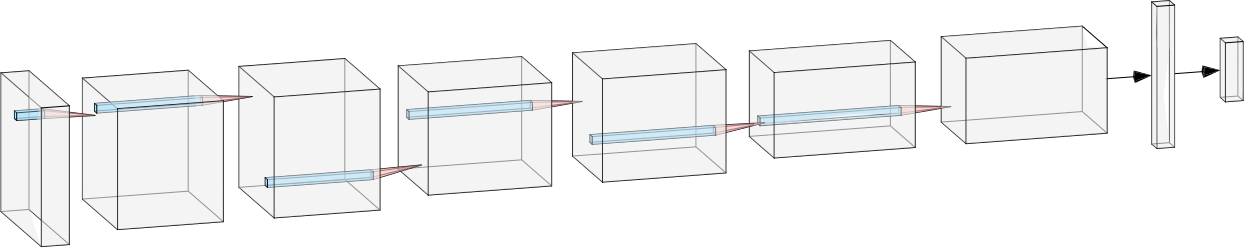

In [ ]:
import torch.nn.functional as F


class YourModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        # TO DO: Your neural network design
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.avg_pool(F.relu(self.conv6(x)))
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
###  Here are some training parameters which you can tweak
batch_size = 128
learning_rate = 1e-3
regularization_rate = 1e-5
n_epochs = 10
use_gpu = True
test_every = 1
momentum = 0.9
###

# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
model = YourModel()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

## DataLoader

Here we provide you the codes for loading the train data, validation data and test data. Please ensure that you understood how PyTorch methods like ImageFolder, DataLoader and transformations work.

In [ ]:
train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

abs_path = "/content/drive/MyDrive/ITU - Computer Engineering/BLG561E/HW2"
train_path = os.path.join(abs_path, 'data/train')
val_path = os.path.join(abs_path, 'data/val')
test_path = os.path.join(abs_path, 'data/test')
train_dataset = ImageFolder(train_path, train_transforms)
val_dataset = ImageFolder(val_path, val_transforms)
test_dataset = ImageFolder(test_path, test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

# Train your own model

Don't forget to include appropriate regularizations. Choose appropriate set of hyperparameters such as Learning Rate etc. You may insert new cells.

In [ ]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
model.train()
if use_gpu:
    model.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []
running_loss = 0

# Write the training loop
for epoch in range(n_epochs):
    for ix, data in enumerate(train_loader):
        optimizer.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        output = model(img)
        loss = criteria(output, label)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        losses_iter_train.append(loss.item())
        if ix % 40 == 39:    # print every 80 mini-batches
            print('Train [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/40))
            running_loss = 0
    running_loss = 0
    losses_epoch_train.append(np.mean(losses_iter_train[epoch*len(train_loader):(epoch+1)*len(train_loader)]))
    print('Train [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_train[epoch]))

    if epoch % test_every == 0:
        with torch.no_grad():
            model.eval()
            val_ix = epoch // test_every
            total_true = 0
            total_false = 0
            for ix, data in enumerate(val_loader):
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                output = model(img)
                loss = criteria(output, label)
                _, prediction = torch.max(output.data, 1)
                total_true += torch.sum(prediction == label)
                total_false += torch.sum(prediction != label)
                # Statistics
                running_loss += loss.item()
                losses_iter_val.append(loss.item())
                if ix % 40 == 39:    # print every 40 mini-batches
                    print('Val [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/40))
                    running_loss = 0
            running_loss = 0
            losses_epoch_val.append(np.mean(losses_iter_val[val_ix*len(val_loader):(val_ix+1)*len(val_loader)]))
            print('Val [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_val[val_ix]))
            print('Val Acc: {:.4}%'.format(100 * total_true / (total_true + total_false)))
        model.train()

Train [1,    40] running loss: 1.92124
Train [Epoch 1] loss: 1.78098
Val [1,    40] running loss: 1.56976
Val [Epoch 1] loss: 1.59005
Val Acc: 44.39%
Train [2,    40] running loss: 1.43433
Train [Epoch 2] loss: 1.40124
Val [2,    40] running loss: 1.40580
Val [Epoch 2] loss: 1.36414
Val Acc: 52.36%
Train [3,    40] running loss: 1.26972
Train [Epoch 3] loss: 1.21789
Val [3,    40] running loss: 1.19426
Val [Epoch 3] loss: 1.19983
Val Acc: 58.26%
Train [4,    40] running loss: 1.05377
Train [Epoch 4] loss: 1.00872
Val [4,    40] running loss: 1.01333
Val [Epoch 4] loss: 0.98230
Val Acc: 65.36%
Train [5,    40] running loss: 0.83896
Train [Epoch 5] loss: 0.79384
Val [5,    40] running loss: 1.01789
Val [Epoch 5] loss: 1.00883
Val Acc: 65.96%
Train [6,    40] running loss: 0.65708
Train [Epoch 6] loss: 0.67400
Val [6,    40] running loss: 1.05509
Val [Epoch 6] loss: 1.00248
Val Acc: 66.16%
Train [7,    40] running loss: 0.59899
Train [Epoch 7] loss: 0.58361
Val [7,    40] running loss: 0.

## Test your model

Measure the performance against test set. Complete the code below.

In [ ]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

model.eval()

with torch.no_grad():
    total_true = 0
    total_false = 0
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        output = model(img)
        _, prediction = torch.max(output.data, 1)
        total_true += torch.sum(prediction == label)
        total_false += torch.sum(prediction != label)
        # Statistics
    print('Test Acc: {:.2f}%'.format(100 * total_true / (total_true + total_false)))

import copy
model_to_save = copy.deepcopy(model)

Test Acc: 66.10%


# Plot your model

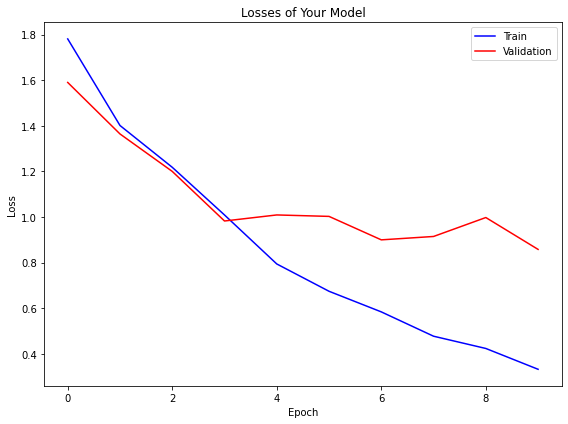

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(losses_epoch_train, c="b", label="Train")
axes.plot(losses_epoch_val, c="r", label="Validation")
axes.set_title("Losses of Your Model")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

My model has achieved pretty respectable validation and test accuracies considering there are no generalization to the data implementations such as dropout or batch normalization. However, the model suffers from overfitting the training data. The momentum of the curves show us that as the number of epochs increase, we will start to see the gap between the validation and the training loss curves get wider.

# Train, Test and Plot Methods

These methods are defined below in order to reduce code duplication in the upcoming cells.

In [ ]:
def train_model(train_loader, val_loader, model, optimizer, criterion, n_epochs=10, test_every=1, print_every=40):
    model.train()
    if use_gpu:
        model.cuda()
        criteria.cuda()

    losses_iter_train = []
    losses_epoch_train = []

    losses_iter_val = []
    losses_epoch_val = []
    running_loss = 0

    # Write the training loop
    for epoch in range(n_epochs):
        for ix, data in enumerate(train_loader):
            optimizer.zero_grad()
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            losses_iter_train.append(loss.item())
            if ix % print_every == print_every - 1:    # print every print_every iteration
                print('Train [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/print_every))
                running_loss = 0
        running_loss = 0
        losses_epoch_train.append(np.mean(losses_iter_train[epoch*len(train_loader):(epoch+1)*len(train_loader)]))
        print('Train [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_train[epoch]))

        if epoch % test_every == 0:
            with torch.no_grad():
                model.eval()
                val_ix = epoch // test_every
                total_true = 0
                total_false = 0
                for ix, data in enumerate(val_loader):
                    img, label = data
                    if use_gpu:
                        img = img.cuda()
                        label = label.cuda()
                    output = model(img)
                    loss = criterion(output, label)
                    _, prediction = torch.max(output.data, 1)
                    total_true += torch.sum(prediction == label)
                    total_false += torch.sum(prediction != label)
                    # Statistics
                    running_loss += loss.item()
                    losses_iter_val.append(loss.item())
                    if ix % print_every == print_every - 1:
                        print('Val [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/print_every))
                        running_loss = 0
                running_loss = 0
                losses_epoch_val.append(np.mean(losses_iter_val[val_ix*len(val_loader):(val_ix+1)*len(val_loader)]))
                print('Val [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_val[val_ix]))
                print('Acc: {:.4}%'.format(100 * total_true / (total_true + total_false)))
            model.train()

    return losses_iter_train, losses_epoch_train, losses_iter_val, losses_epoch_val

In [ ]:
def test_model(test_loader, model):
    model.eval()

    with torch.no_grad():
        total_true = 0
        total_false = 0
        for data in test_loader:
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            output = model(img)
            _, prediction = torch.max(output.data, 1)
            total_true += torch.sum(prediction == label)
            total_false += torch.sum(prediction != label)
            # Statistics
        test_acc = 100 * total_true / (total_true + total_false)
        print('Test Acc: {:.2f}%'.format(test_acc))
    
    return test_acc

In [ ]:
def plot_model(train_losses, val_losses, title=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axes.plot(train_losses, c="b", label="Train")
    axes.plot(val_losses, c="r", label="Validation")
    if title:
        axes.set_title(title)
    else:
        axes.set_title("Epoch Losses")
    axes.set_xlabel("Epoch")
    axes.set_ylabel("Loss")
    axes.legend(loc="best")
    fig.tight_layout()

# ResNet-50
## Train ResNet-50

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [ ]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model
model = resnet50
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

_, resnet_train_losses, _, resnet_val_losses = train_model(train_loader, val_loader, model, optimizer, criteria, n_epochs=10)

Train [1,    40] running loss: 1.72531
Train [Epoch 1] loss: 1.39997
Val [1,    40] running loss: 0.77440
Val [Epoch 1] loss: 0.76171
Acc: 85.6%
Train [2,    40] running loss: 0.65682
Train [Epoch 2] loss: 0.60577
Val [2,    40] running loss: 0.50710
Val [Epoch 2] loss: 0.49067
Acc: 89.32%
Train [3,    40] running loss: 0.46456
Train [Epoch 3] loss: 0.43497
Val [3,    40] running loss: 0.41305
Val [Epoch 3] loss: 0.39635
Acc: 90.64%
Train [4,    40] running loss: 0.37586
Train [Epoch 4] loss: 0.35938
Val [4,    40] running loss: 0.34952
Val [Epoch 4] loss: 0.34003
Acc: 91.64%
Train [5,    40] running loss: 0.32495
Train [Epoch 5] loss: 0.31941
Val [5,    40] running loss: 0.30956
Val [Epoch 5] loss: 0.30528
Acc: 92.5%
Train [6,    40] running loss: 0.29348
Train [Epoch 6] loss: 0.28745
Val [6,    40] running loss: 0.28802
Val [Epoch 6] loss: 0.27910
Acc: 93.1%
Train [7,    40] running loss: 0.26442
Train [Epoch 7] loss: 0.26319
Val [7,    40] running loss: 0.26983
Val [Epoch 7] loss: 0

## Testing

In [ ]:
# You can use the same testing mechanism above. Now, you will use the ResNet model you trained above
resnet_acc = test_model(test_loader, model)

Test Acc: 72.22%


### Plot the training and validation losses versus number of iterations or epochs for ResNet-50 on the same plot and obtain test accuracy

Test Acc: 72.22%


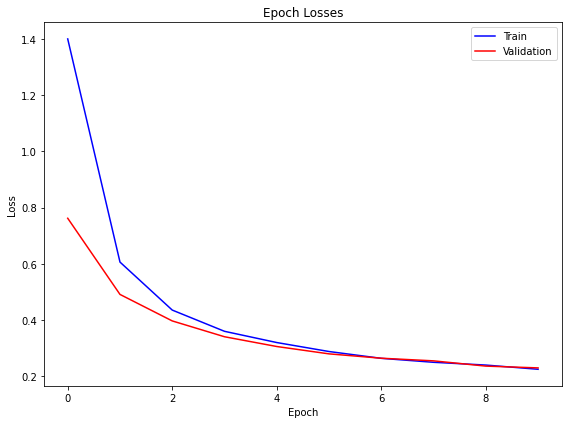

In [ ]:
print('Test Acc: {:.2f}%'.format(resnet_acc))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(resnet_train_losses, c="b", label="Train")
axes.plot(resnet_val_losses, c="r", label="Validation")
axes.set_title("Epoch Losses")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

Pretrained ResNet50 has performed quite well on the validation set, however even though it neither overfit nor underfit the training data, its test set score isn't as remarkable as scores obtained on the validation set.

# DenseNet-121
## Train DenseNet-121

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [ ]:
# You can use the same training mechanism above. Now, you will use DenseNet-121 as your model 
model = densenet121
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

_, densenet_train_losses, _, densenet_val_losses = train_model(train_loader, val_loader, model, optimizer, criteria, n_epochs=10)

Train [1,    40] running loss: 1.73237
Train [Epoch 1] loss: 1.40433
Val [1,    40] running loss: 0.80028
Val [Epoch 1] loss: 0.76817
Acc: 85.4%
Train [2,    40] running loss: 0.65681
Train [Epoch 2] loss: 0.59874
Val [2,    40] running loss: 0.50522
Val [Epoch 2] loss: 0.48463
Acc: 89.91%
Train [3,    40] running loss: 0.45745
Train [Epoch 3] loss: 0.43720
Val [3,    40] running loss: 0.40986
Val [Epoch 3] loss: 0.39382
Acc: 90.78%
Train [4,    40] running loss: 0.37184
Train [Epoch 4] loss: 0.35836
Val [4,    40] running loss: 0.35569
Val [Epoch 4] loss: 0.34052
Acc: 91.97%
Train [5,    40] running loss: 0.31785
Train [Epoch 5] loss: 0.31235
Val [5,    40] running loss: 0.32154
Val [Epoch 5] loss: 0.30449
Acc: 92.83%
Train [6,    40] running loss: 0.28753
Train [Epoch 6] loss: 0.28621
Val [6,    40] running loss: 0.30377
Val [Epoch 6] loss: 0.28592
Acc: 92.57%
Train [7,    40] running loss: 0.26767
Train [Epoch 7] loss: 0.26147
Val [7,    40] running loss: 0.27835
Val [Epoch 7] loss:

## Testing

In [ ]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
densenet_acc = test_model(test_loader, model)

Test Acc: 86.54%


### Plot the training and validation losses versus number of iterations or epochs for DenseNet-121 on the same plot and obtain test accuracy

Test Acc: 86.54%


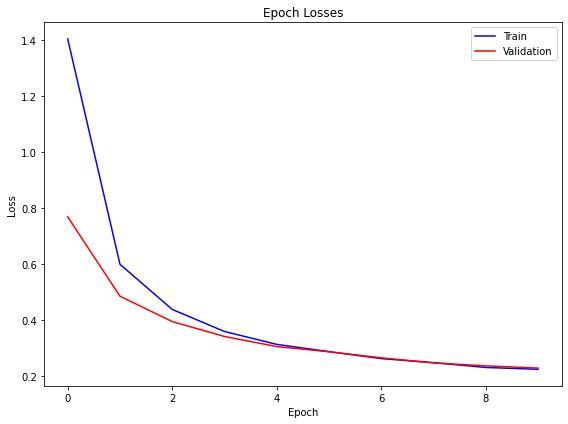

In [ ]:
print('Test Acc: {:.2f}%'.format(densenet_acc))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(densenet_train_losses, c="b", label="Train")
axes.plot(densenet_val_losses, c="r", label="Validation")
axes.set_title("Epoch Losses")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

Pretrained DenseNet121 has performed quite well both on the validation set and the test set without any signs of over/under-fitting.

# BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.
class BatchNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv2.out_channels)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv4.out_channels)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv6.out_channels)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avg_pool(F.relu(self.bn3(self.conv6(x))))
        x = x.view(-1, 256 * 14 * 14)
        x = self.fc1(x)
        return x


bn_model = BatchNormModel()
bnmodel_optimizer = optim.Adam(bn_model.parameters(), lr=learning_rate, weight_decay=regularization_rate)
_, bnmodel_train_losses, _, bnmodel_val_losses = train_model(train_loader, val_loader, bn_model, bnmodel_optimizer, criteria)

Train [1,    40] running loss: 4.68809
Train [Epoch 1] loss: 3.49463
Val [1,    40] running loss: 2.52018
Val [Epoch 1] loss: 2.42203
Acc: 35.5%
Train [2,    40] running loss: 1.65406
Train [Epoch 2] loss: 1.56948
Val [2,    40] running loss: 2.06513
Val [Epoch 2] loss: 2.00264
Acc: 42.47%
Train [3,    40] running loss: 1.33800
Train [Epoch 3] loss: 1.26580
Val [3,    40] running loss: 1.19735
Val [Epoch 3] loss: 1.17234
Acc: 59.06%
Train [4,    40] running loss: 1.06600
Train [Epoch 4] loss: 1.01339
Val [4,    40] running loss: 1.23642
Val [Epoch 4] loss: 1.16594
Acc: 61.05%
Train [5,    40] running loss: 1.09669
Train [Epoch 5] loss: 1.04697
Val [5,    40] running loss: 1.23336
Val [Epoch 5] loss: 1.12506
Acc: 61.98%
Train [6,    40] running loss: 0.87038
Train [Epoch 6] loss: 0.85654
Val [6,    40] running loss: 1.21366
Val [Epoch 6] loss: 1.16901
Acc: 61.65%
Train [7,    40] running loss: 0.77593
Train [Epoch 7] loss: 0.78014
Val [7,    40] running loss: 0.91536
Val [Epoch 7] loss:

In [ ]:
# Define your model without BatchNorm and train it. Skip this if you use YourModel() for this condition.
your_model = YourModel()
yourmodel_optimizer = optim.Adam(your_model.parameters(), lr=learning_rate, weight_decay=regularization_rate)
_, yourmodel_train_losses, _, yourmodel_val_losses = train_model(train_loader, val_loader, your_model, yourmodel_optimizer, criteria)

Train [1,    40] running loss: 2.04882
Train [Epoch 1] loss: 1.87677
Val [1,    40] running loss: 1.75741
Val [Epoch 1] loss: 1.78585
Acc: 41.61%
Train [2,    40] running loss: 1.50828
Train [Epoch 2] loss: 1.43394
Val [2,    40] running loss: 1.43080
Val [Epoch 2] loss: 1.37985
Acc: 51.89%
Train [3,    40] running loss: 1.20821
Train [Epoch 3] loss: 1.14818
Val [3,    40] running loss: 1.11970
Val [Epoch 3] loss: 1.14547
Acc: 61.84%
Train [4,    40] running loss: 0.92898
Train [Epoch 4] loss: 0.89017
Val [4,    40] running loss: 1.03788
Val [Epoch 4] loss: 0.97892
Acc: 64.9%
Train [5,    40] running loss: 0.74938
Train [Epoch 5] loss: 0.73274
Val [5,    40] running loss: 0.99409
Val [Epoch 5] loss: 0.98122
Acc: 66.49%
Train [6,    40] running loss: 0.64457
Train [Epoch 6] loss: 0.64102
Val [6,    40] running loss: 0.90206
Val [Epoch 6] loss: 0.86268
Acc: 70.27%
Train [7,    40] running loss: 0.55042
Train [Epoch 7] loss: 0.53508
Val [7,    40] running loss: 0.88691
Val [Epoch 7] loss:

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

Test Acc: 65.24%


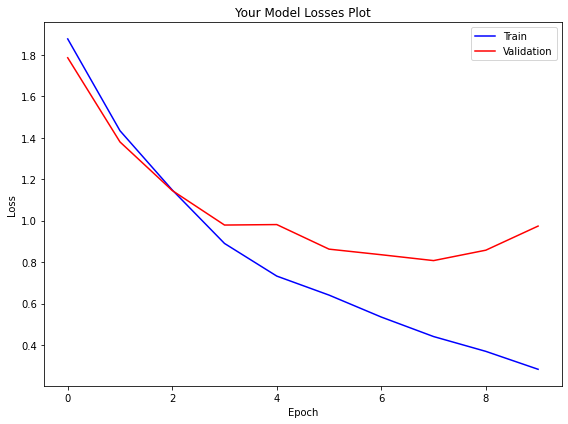

In [ ]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Your Model Losses Plot")

Test Acc: 63.11%


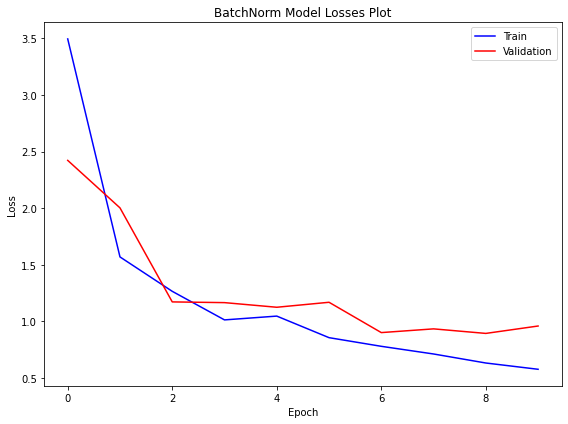

In [ ]:
bnmodel_acc = test_model(test_loader, bn_model)
plot_model(bnmodel_train_losses, bnmodel_val_losses, "BatchNorm Model Losses Plot")

Batch normalization helped stabilize the learning process as expected and kept the loss curves closer to one another. Given a few more epochs, the model using batch normalization might get higher test accuracies as well. Please note that the test accuracy of YourModel() differs from the initial one because weights are randomly initialized each run and YourModel() is trained from scratch TWICE. This is intentional in order to show the results in a more compact fashion.

# Dropout Comparison

**Create two models one with dropout layers and one without dropout layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Define your model with Dropout and train it. Skip this if you use YourModel() for this condition.
class DropoutModel(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.dropout = nn.Dropout(p)
        self.fc1 = nn.Linear(256 * 14 * 14, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.avg_pool(F.relu(self.conv6(x)))
        x = self.dropout(x)
        x = x.view(-1, 256 * 14 * 14)
        x = self.fc1(x)
        return x


dropout_model = DropoutModel()
dropoutmodel_optimizer = optim.Adam(dropout_model.parameters(), lr=learning_rate, weight_decay=regularization_rate)
_, dropoutmodel_train_losses, _, dropoutmodel_val_losses = train_model(train_loader, val_loader, dropout_model, dropoutmodel_optimizer, criteria)

Train [1,    40] running loss: 1.82920
Train [Epoch 1] loss: 1.70606
Val [1,    40] running loss: 1.58160
Val [Epoch 1] loss: 1.48349
Acc: 46.25%
Train [2,    40] running loss: 1.39918
Train [Epoch 2] loss: 1.33710
Val [2,    40] running loss: 1.59086
Val [Epoch 2] loss: 1.75440
Acc: 49.04%
Train [3,    40] running loss: 1.17370
Train [Epoch 3] loss: 1.12690
Val [3,    40] running loss: 1.36738
Val [Epoch 3] loss: 1.43393
Acc: 53.62%
Train [4,    40] running loss: 0.97419
Train [Epoch 4] loss: 0.95346
Val [4,    40] running loss: 0.98514
Val [Epoch 4] loss: 0.95079
Acc: 67.22%
Train [5,    40] running loss: 0.81400
Train [Epoch 5] loss: 0.80386
Val [5,    40] running loss: 0.98369
Val [Epoch 5] loss: 0.97138
Acc: 67.22%
Train [6,    40] running loss: 0.72221
Train [Epoch 6] loss: 0.72537
Val [6,    40] running loss: 0.83812
Val [Epoch 6] loss: 0.88876
Acc: 70.54%
Train [7,    40] running loss: 0.66920
Train [Epoch 7] loss: 0.67534
Val [7,    40] running loss: 0.98353
Val [Epoch 7] loss

In [ ]:
# Define your model without Dropout and train it. Skip this if you use YourModel() for this condition.

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

Test Acc: 65.24%


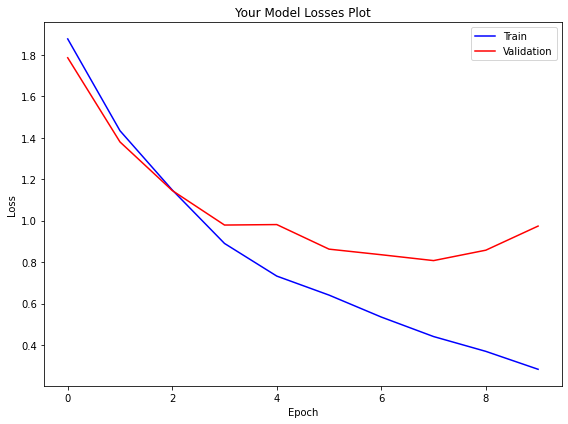

In [ ]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Your Model Losses Plot")

Test Acc: 65.03%


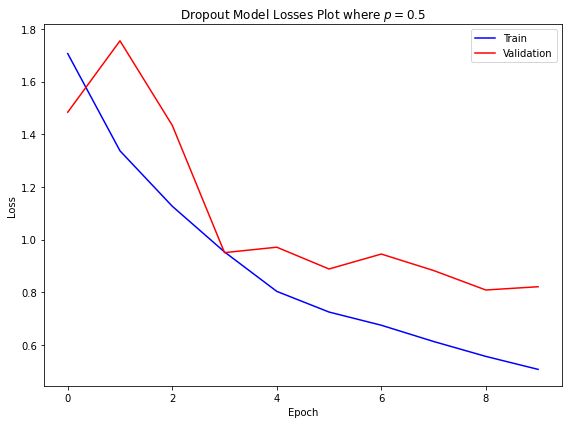

In [ ]:
dropoutmodel_acc = test_model(test_loader, dropout_model)
plot_model(dropoutmodel_train_losses, dropoutmodel_val_losses, "Dropout Model Losses Plot where $p=0.5$")

A similar conclusion can be made for the dropout as well. By randomly choosing which neurons to activate at the fully connected output of our model at each run, our model generalized to the data better and achieved less validation losses as the number of epochs increase. The spike on the validation loss seen on the first epoch is understandable due to dropout being a randomized operation.

# Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam. If your training for YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Train your model with SGD+Momentum. Skip this if you use YourModel() for this condition.
sgd_model = YourModel()
sgd_optimizer = optim.SGD(sgd_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, sgd_train_losses, _, sgd_val_losses = train_model(train_loader, val_loader, sgd_model, sgd_optimizer, criteria)

Train [1,    40] running loss: 2.29525
Train [Epoch 1] loss: 2.29063
Val [1,    40] running loss: 2.27957
Val [Epoch 1] loss: 2.27891
Acc: 19.24%
Train [2,    40] running loss: 2.27082
Train [Epoch 2] loss: 2.26415
Val [2,    40] running loss: 2.23663
Val [Epoch 2] loss: 2.24276
Acc: 19.24%
Train [3,    40] running loss: 2.22704
Train [Epoch 3] loss: 2.21050
Val [3,    40] running loss: 2.13441
Val [Epoch 3] loss: 2.17319
Acc: 19.24%
Train [4,    40] running loss: 2.14701
Train [Epoch 4] loss: 2.11836
Val [4,    40] running loss: 1.96991
Val [Epoch 4] loss: 2.03793
Acc: 25.81%
Train [5,    40] running loss: 1.98307
Train [Epoch 5] loss: 1.94474
Val [5,    40] running loss: 1.83546
Val [Epoch 5] loss: 1.88280
Acc: 33.18%
Train [6,    40] running loss: 1.83748
Train [Epoch 6] loss: 1.81333
Val [6,    40] running loss: 1.74682
Val [Epoch 6] loss: 1.77084
Acc: 37.09%
Train [7,    40] running loss: 1.73356
Train [Epoch 7] loss: 1.70168
Val [7,    40] running loss: 1.67770
Val [Epoch 7] loss

In [ ]:
# Train your model with Adam. Skip this if you use YourModel() for this condition.

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Test Acc: 43.87%


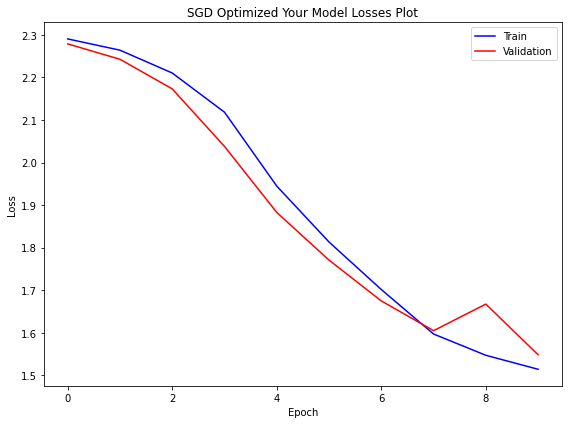

In [ ]:
sgd_acc = test_model(test_loader, sgd_model)
plot_model(sgd_train_losses, sgd_val_losses, "SGD Optimized Your Model Losses Plot")

Test Acc: 65.24%


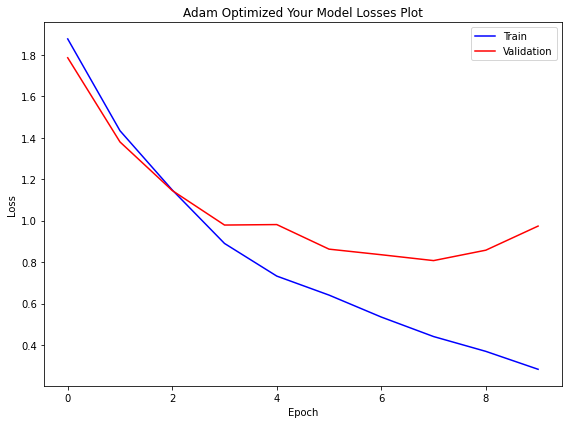

In [ ]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Adam Optimized Your Model Losses Plot")

Adam optimizer has helped the model to learn and fit to the data a lot faster than SGD, by taking optimization steps resulted from computation of the decaying average of past squared gradients (RMSProp alike) and past gradients (SGD with momentum alike). Thanks to this, we are able to observe within 4 to 6 epochs that our model will start to overfit. On the other hand, SGD neither converged to the loss function's minima as fast, nor, as a result, achieved good accuracy scores within 10 epochs. However, given more epochs, SGD optimizer may come close to the results achieved by the Adam optimizer. Because judging by the loss curves plot, quite clearly, validation loss will keep decreasing.

#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: [Link to Model](https://drive.google.com/file/d/1mkcXGJcRVDsCa_nkOQ2eOrhveeDB3M4E/view?usp=sharing) (https://drive.google.com/file/d/1mkcXGJcRVDsCa_nkOQ2eOrhveeDB3M4E/view?usp=sharing)

In [ ]:
student_id = 150180705
model_path = os.path.join(abs_path, '{}.pth'.format(student_id))
torch.save(model_to_save.state_dict(), model_path)